<a href="https://colab.research.google.com/github/gideonoludeyi/cosc5p70/blob/main/notebooks/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Data: Predict Students' Dropout and Academic Success

@misc{predict_students'_dropout_and_academic_success_697,
  author       = {Realinho, Valentim, Vieira Martins, Mónica, Machado, Jorge, and Baptista, Luís},
  title        = {{Predict Students' Dropout and Academic Success}},
  year         = {2021},
  howpublished = {UCI Machine Learning Repository},
  note         = {{DOI}: [https://doi.org/10.24432/C5MC89](https://doi.org/10.24432/C5MC89)}
}

In [1]:
!pip install "ucimlrepo" "pandas" "numpy" "matplotlib" "torch" "scikit-learn"

In [2]:
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim
import random
import time
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

In [3]:
from ucimlrepo import fetch_ucirepo

# fetch dataset - https://archive.ics.uci.edu/dataset/697
repo = fetch_ucirepo(id=697)

# data (as pandas dataframes)
X = repo.data.features

X_norm = nn.functional.normalize(torch.from_numpy(X.values), p=2, dim=1)
y = repo.data.targets['Target']

X = pd.DataFrame(X_norm.numpy(), columns=X.columns)

# metadata
# print(repo.metadata)

# variable information
# print(repo.variables)

In [4]:
df = pd.concat([repo.data.features, repo.data.targets['Target']], axis=1)
df.to_csv('data.csv', index=True)

In [5]:
# Fixing the random seed to guarantee deterministic results
def set_seed(seed):
    import os
    import random
    import numpy as np
    import torch
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

#seed = 123456789
seed = int(time.time() * 1000) % (2**32)

set_seed(seed)
rng = torch.Generator().manual_seed(seed)

In [6]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 36 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Marital Status                                  4424 non-null   float64
 1   Application mode                                4424 non-null   float64
 2   Application order                               4424 non-null   float64
 3   Course                                          4424 non-null   float64
 4   Daytime/evening attendance                      4424 non-null   float64
 5   Previous qualification                          4424 non-null   float64
 6   Previous qualification (grade)                  4424 non-null   float64
 7   Nacionality                                     4424 non-null   float64
 8   Mother's qualification                          4424 non-null   float64
 9   Father's qualification                   

In [7]:
X = X.drop(columns=['Gender', 'Nacionality'])

In [8]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 34 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Marital Status                                  4424 non-null   float64
 1   Application mode                                4424 non-null   float64
 2   Application order                               4424 non-null   float64
 3   Course                                          4424 non-null   float64
 4   Daytime/evening attendance                      4424 non-null   float64
 5   Previous qualification                          4424 non-null   float64
 6   Previous qualification (grade)                  4424 non-null   float64
 7   Mother's qualification                          4424 non-null   float64
 8   Father's qualification                          4424 non-null   float64
 9   Mother's occupation                      

In [9]:
X.describe()

,Marital Status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Mother's qualification,Father's qualification,Mother's occupation,...,Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP
count,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,...,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000
mean,0.000324,0.004356,0.000477,0.980495,0.000288,0.001083,0.040599,0.005127,0.006014,0.002437,...,0.000015,0.000283,0.001153,0.001482,0.000851,0.001590,0.000025,0.003452,0.000351,0.000038
std,0.000860,0.017999,0.001556,0.086786,0.000838,0.007689,0.113942,0.018795,0.021118,0.011086,...,0.000075,0.002919,0.004894,0.006274,0.004149,0.005018,0.000291,0.009820,0.001506,0.002068
min,0.000100,0.000100,0.000000,0.151658,0.000000,0.000100,0.009823,0.000100,0.000100,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000760,-0.003446,-0.016213
25%,0.000105,0.000109,0.000105,0.999746,0.000103,0.000105,0.013309,0.000304,0.000330,0.000421,...,0.000000,0.000000,0.000550,0.000656,0.000219,0.001137,0.000000,0.000989,0.000032,-0.000184
50%,0.000108,0.001837,0.000110,0.999785,0.000108,0.000108,0.014286,0.002077,0.003120,0.000683,...,0.000000,0.000000,0.000649,0.000842,0.000541,0.001314,0.000000,0.001224,0.000143,0.000035
75%,0.000110,0.004263,0.000220,0.999811,0.000110,0.000111,0.015260,0.003999,0.004004,0.000974,...,0.000000,0.000000,0.000748,0.001093,0.000660,0.001443,0.000000,0.001522,0.000284,0.000194
max,0.009554,0.262869,0.023949,0.999885,0.005837,0.204277,0.745404,0.221806,0.215969,0.464207,...,0.001321,0.064730,0.081711,0.109082,0.072135,0.071404,0.013787,0.094559,0.014809,0.019657


In [10]:
# There are three labels: 'Dropout', 'Enrolled', and 'Graduate'
# But there are way more instances of 'Graduate'.
#   could it lead to bias in the model?
y.value_counts()

,count
Target,
Graduate,2209
Dropout,1421
Enrolled,794


In [11]:
# Samples from the data
X.sample(10, random_state=seed)

,Marital Status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Mother's qualification,Father's qualification,Mother's occupation,...,Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP
2379,0.000110,0.000110,0.000110,0.999784,0.000110,0.000110,0.014564,0.000219,0.004052,0.000986,...,0.000000,0.000000,0.000657,0.000876,0.000657,0.001369,0.000000,0.001358,0.000055,0.000196
15,0.000102,0.000102,0.000102,0.999824,0.000102,0.000102,0.012993,0.001944,0.003785,0.000921,...,0.000000,0.000000,0.000614,0.000716,0.000000,0.000000,0.000000,0.001586,0.000286,-0.000415
4140,0.000433,0.000757,0.000108,0.999653,0.000108,0.004328,0.014067,0.003679,0.003679,0.010713,...,0.000000,0.000000,0.000649,0.000000,0.000000,0.000000,0.000000,0.001201,0.000065,0.000219
1949,0.000105,0.001894,0.000105,0.999828,0.000105,0.000105,0.012103,0.003999,0.003894,0.000526,...,0.000000,0.000000,0.000842,0.000947,0.000737,0.001298,0.000000,0.001631,0.000295,-0.000427
947,0.000102,0.001739,0.000205,0.999819,0.000102,0.000102,0.013617,0.000307,0.000512,0.000000,...,0.000000,0.000000,0.000409,0.000818,0.000000,0.000000,0.000000,0.000778,0.000266,0.000033
2363,0.000110,0.004824,0.000110,0.999736,0.000110,0.004276,0.015349,0.000110,0.002083,0.000439,...,0.000000,0.000000,0.000548,0.000658,0.000219,0.001279,0.000000,0.001184,0.000153,0.000191
1404,0.000109,0.004809,0.000109,0.999760,0.000109,0.004263,0.014209,0.000219,0.004044,0.000219,...,0.000000,0.000000,0.000546,0.000546,0.000000,0.000000,0.000000,0.001694,0.000306,-0.000444
4149,0.000105,0.004525,0.000316,0.999730,0.000105,0.000105,0.014628,0.003999,0.003894,0.000947,...,0.000105,0.001158,0.001473,0.002736,0.001263,0.001412,0.000105,0.000800,0.000274,0.000034
689,0.000437,0.004263,0.000219,0.999754,0.000109,0.002077,0.014548,0.004044,0.004044,0.000984,...,0.000000,0.000000,0.000546,0.000984,0.000000,0.000000,0.000000,0.001180,0.000153,0.000190
2749,0.000200,0.003903,0.000100,0.999776,0.000000,0.000100,0.015010,0.003703,0.003703,0.000901,...,0.000000,0.000000,0.000500,0.000600,0.000500,0.001161,0.000100,0.000761,0.000260,0.000032


In [12]:
# Data splitting - training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, shuffle=True, random_state=seed)
mean = X_train.mean(axis=0)
std = X_train.std(axis=0)
X_train = (X_train - mean) / std
X_test = (X_test - mean) / std

print(f"Train set size: {len(y_train)} ({len(y_train) / len(y):.2f})")
print(f"Test  set size: {len(y_test)}  ({len(y_test) / len(y):.2f})")

Train set size: 3539 (0.80)
Test  set size: 885  (0.20)


In [13]:
def label_to_index(label):
  map = {'Dropout': 0, 'Enrolled': 1, 'Graduate': 2}
  return map[label]

def index_to_label(index):
  map = {0: 'Dropout', 1: 'Enrolled', 2: 'Graduate'}
  return map[index]

In [14]:
y_train = y_train.apply(label_to_index)
y_test = y_test.apply(label_to_index)

In [15]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, weights=None):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.weights = weights

    def forward(self, inputs, targets):
        BCE_loss = nn.CrossEntropyLoss(weight=self.weights)(inputs, targets)
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss
        return F_loss

In [16]:
class SupervisedDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = np.asarray(X)
        self.y = np.asarray(y)
        self.transform = transform # function to process the features
        #self.target_transform = target_transform # function to process the label

    def __getitem__(self, index):
        features = self.X[index]
        label = self.y[index]
        if self.transform is not None:
            features = self.transform(features)
        #if self.target_transform is not None:
        #    label = self.target_transform(label)
        return features, label

    def __len__(self):
        return len(self.y)

In [17]:
def train_step(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    batch_size = dataloader.batch_size
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Convert X and y to float tensors to match model requirements
        X, y = X.clone().detach().float(), y.clone().detach().long()

        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % (batch_size // 4) == 0:
            loss = loss.item()
            current = batch * dataloader.batch_size + len(X)
            #print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_step(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            X, y = torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.long)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    return test_loss, correct

In [18]:
# Neural network architecture (36 x 256 x 128 x 64 x 3)

input_dimensions = np.shape(X_train)[1]

print(f"Input dimensions: {input_dimensions}")

model = nn.Sequential(
    nn.Linear(input_dimensions, 256),  # First hidden layer
    nn.BatchNorm1d(256),               # Normalize activations
    nn.ReLU(),
    nn.Dropout(0.3),                   # Regularization
    nn.Linear(256, 128),                # Second hidden layer
    nn.BatchNorm1d(128),                # Normalize activations
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(128, 64),               # Third hidden layer
    nn.BatchNorm1d(64),                # Normalize activations
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(64, 3)                   # Output layer
)

print(model)

Input dimensions: 34
Sequential(
  (0): Linear(in_features=34, out_features=256, bias=True)
  (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Dropout(p=0.3, inplace=False)
  (4): Linear(in_features=256, out_features=128, bias=True)
  (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): Dropout(p=0.3, inplace=False)
  (8): Linear(in_features=128, out_features=64, bias=True)
  (9): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): Dropout(p=0.3, inplace=False)
  (12): Linear(in_features=64, out_features=3, bias=True)
)


In [19]:
learning_rate = 0.001
epochs = 1000
momentum=0.9
batch_size = 64

In [20]:
classes_train = np.unique(y_train)
loss_weights = compute_class_weight('balanced', classes=classes_train, y=y_train)
loss_weights = torch.tensor(loss_weights, dtype=torch.float32)
print(f"Classes:      {classes_train}")
print(f"Loss Weights: {loss_weights}")

# Loss function
#  assign weights labels due to imbalance in labels
#  e.g., there are more 'Graduate' instances than 'Enrolled' and 'Dropout'
#        so 'Graduate' label is assigned a lower weight in term of loss
loss_fn = FocalLoss(alpha=1, gamma=2, weights=loss_weights)

Classes:      [0 1 2]
Loss Weights: tensor([1.0375, 1.8577, 0.6676])


In [21]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

In [22]:
train_data = SupervisedDataset(X_train, y_train)
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, generator=rng)

test_data = SupervisedDataset(X_test, y_test)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True, generator=rng)

best_accuracy = float('-inf')

for epoch in range(epochs):
    # Training step
    train_step(train_dataloader, model, loss_fn, optimizer)
    # Validation step
    test_loss, accuracy = test_step(test_dataloader, model, loss_fn)

    if epoch % 50 == 0:
      print(f"Epoch {epoch + 1}\n-------------------------------")
      print(f"Test Error: \n test_loss: {(100*accuracy):>0.1f}%, avg.loss: {test_loss:>8f} \n")

    # Below simply stops the training process if no improvement has happened for a while
    # This way, if we oscillate, we only take the best weights before decreasing
    # Check if validation loss improved
    if accuracy > best_accuracy:
        best_accuracy = accuracy  # Update the best validation loss
        # Save the model with the best performance
        torch.save(model.state_dict(), "best_model.pth")
        if epoch % 50 == 0:
          print(f"Validation loss improved to {(100*best_accuracy):>0.1f}%")
    else:
        if epoch % 50 == 0:
          print(f"No improvement. Best accuracy is still: {(100*best_accuracy):>0.1f}%")

<ipython-input-17-8b5855e6d512>:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X, y = torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.long)


Epoch 1
-------------------------------
Test Error: 
 test_loss: 49.6%, avg.loss: 0.488147 

Validation loss improved to 49.6%
Epoch 51
-------------------------------
Test Error: 
 test_loss: 69.2%, avg.loss: 0.240170 

Validation loss improved to 69.2%
Epoch 101
-------------------------------
Test Error: 
 test_loss: 67.8%, avg.loss: 0.216401 

No improvement. Best accuracy is still: 70.3%
Epoch 151
-------------------------------
Test Error: 
 test_loss: 68.5%, avg.loss: 0.218254 

No improvement. Best accuracy is still: 70.3%
Epoch 201
-------------------------------
Test Error: 
 test_loss: 69.5%, avg.loss: 0.212049 

No improvement. Best accuracy is still: 70.6%
Epoch 251
-------------------------------
Test Error: 
 test_loss: 69.6%, avg.loss: 0.208057 

No improvement. Best accuracy is still: 70.6%
Epoch 301
-------------------------------
Test Error: 
 test_loss: 68.7%, avg.loss: 0.217219 

No improvement. Best accuracy is still: 70.6%
Epoch 351
------------------------------

In [23]:
def predict(model, X):
    y_pred = []
    with torch.no_grad():
        X = torch.tensor(X, dtype=torch.float32)
        pred = model(X)
        y_pred = pred.argmax(1)
    return np.asarray(y_pred)

def get_result(model, features_df, y_true):
    X = features_df.values
    y_pred = predict(model, X)
    result_df = features_df.copy()
    result_df['y_true'] = y_true
    result_df['y_true'] = result_df['y_true'].apply(index_to_label)
    result_df['y_pred'] = y_pred
    result_df['y_pred'] = result_df['y_pred'].apply(index_to_label)
    return result_df

In [24]:
test_result_df = get_result(model, X_test, y_test.values)
test_result_df

,Marital Status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Mother's qualification,Father's qualification,Mother's occupation,...,Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,y_true,y_pred
4361,-0.250289,-0.141170,-0.239107,0.217203,-0.213487,-0.125630,-0.218200,-0.253267,-0.268938,-0.186037,...,-0.064571,-0.101673,-0.002486,-0.037156,-0.082704,-0.247596,-0.289769,-0.197301,Graduate,Graduate
1934,-0.250284,-0.233372,-0.025716,0.217675,-0.213482,-0.125630,-0.229370,-0.166372,-0.090476,-0.124665,...,-0.064564,-0.052572,-0.027420,-0.048021,-0.082704,-0.214993,-0.196728,0.065130,Graduate,Enrolled
0,4.320365,3.505920,13.285044,-3.359775,4.516039,0.351037,4.025572,3.674972,2.054752,1.472187,...,-0.232339,-0.232588,-0.202016,-0.315373,-0.082704,4.136496,3.597828,3.524652,Dropout,Dropout
2898,-0.250286,-0.135405,0.116534,0.217478,-0.213484,-0.125630,-0.222892,-0.253267,-0.187357,-0.177270,...,-0.064567,-0.101670,-0.027423,-0.056602,-0.082704,-0.211735,0.032295,-0.121408,Graduate,Graduate
1029,-0.250284,-0.233372,-0.025716,0.217673,-0.213482,-0.125630,-0.226646,-0.264128,-0.279135,-0.124665,...,-0.064564,-0.101667,-0.027420,-0.037837,-0.082704,-0.211733,0.032300,-0.121409,Graduate,Graduate
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3308,-0.250287,-0.233372,0.116532,0.217417,-0.213485,-0.125630,-0.222893,-0.166374,-0.187357,-0.194804,...,-0.064568,-0.101670,-0.002482,-0.035717,-0.082704,-0.247594,-0.289770,-0.197304,Graduate,Graduate
4113,0.115177,-0.015697,-0.168806,0.217824,-0.214225,-0.125704,-0.230101,-0.064392,-0.096678,-0.142559,...,-0.086394,-0.232588,-0.202016,-0.315373,-0.082704,-0.233065,-0.132900,0.061913,Dropout,Dropout
2896,-0.256320,-0.025432,-0.242601,0.217451,-0.340527,-0.126259,-0.247213,-0.078495,-0.104850,-0.153553,...,-0.132635,-0.139225,-0.083436,-0.077531,-0.082704,-0.206119,-0.252930,0.009604,Enrolled,Enrolled
3999,-0.250291,-0.141171,0.116519,0.217073,-0.213488,-0.125630,-0.216323,-0.264128,-0.090486,-0.168504,...,-0.064573,-0.101674,-0.002488,-0.019129,-0.082704,-0.198701,-0.253984,0.011678,Dropout,Graduate


In [25]:
# This calculates Predictive parity according to the formula
# PP = (number of true prediction)/(total number) per group
# The result slightly not fair to group 1 ()

predictive_parity = test_result_df.groupby(test_result_df['International']).apply(
    lambda group: (group['y_true'] == group['y_pred']).mean()
).rename("Predictive Parity")

predictive_parity


<ipython-input-25-80a1dd22a169>:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  predictive_parity = test_result_df.groupby(test_result_df['International']).apply(


,Predictive Parity
International,
-0.060837,0.618497
0.407054,0.000000
0.413557,0.000000
0.417456,1.000000
0.417470,1.000000
0.422554,0.000000
0.422574,1.000000
0.422579,1.000000
0.428300,0.000000


In [26]:
test_result_df.to_csv('test_result.csv', index=True)

In [27]:
torch.save(model.state_dict(), "model.pth")
from google.colab import files
files.download("model.pth")

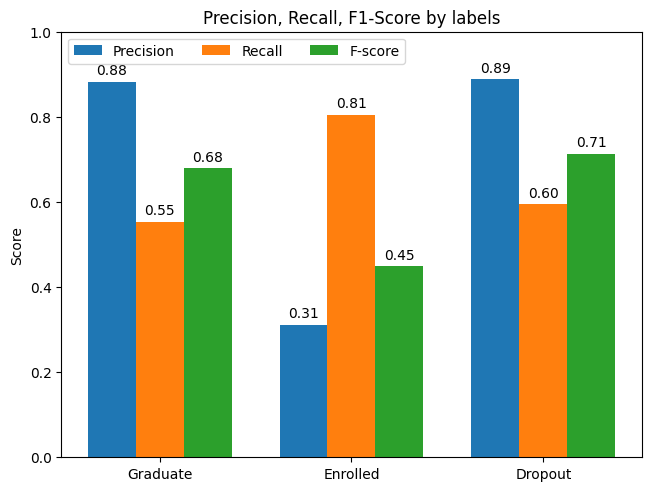

In [29]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support

def plot_precision_recall_fscore(y_true, y_pred, ax=None):
    if ax is None:
        fig, ax = plt.subplots(layout='constrained')

    precision, recall, fscore, _ = precision_recall_fscore_support(y_true, y_pred, average=None)
    labels = ("Graduate", "Enrolled", "Dropout")
    penguin_means = {
        'Precision': (precision[0], precision[1], precision[2]),
        'Recall': (recall[0], recall[1], recall[2]),
        'F-score': (fscore[0], fscore[1], fscore[2]),
    }

    x = np.arange(len(labels))  # the label locations
    width = 0.25  # the width of the bars
    multiplier = 0

    for attribute, measurement in penguin_means.items():
        offset = width * multiplier
        rects = ax.bar(x + offset, measurement, width, label=attribute)
        ax.bar_label(rects, padding=3, fmt='%.2f')
        multiplier += 1

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Score')
    ax.set_title('Precision, Recall, F1-Score by labels')
    ax.set_xticks(x + width, labels)
    ax.legend(loc='upper left', ncols=3)
    ax.set_ylim(0, 1)

    return ax

plot_precision_recall_fscore(test_result_df['y_true'].values, test_result_df['y_pred'].values)
plt.show()

In [33]:
mean.to_csv('mean.csv', index=True)
std.to_csv('std.csv', index=True)